# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()
# 118 for age is the coding for N/A

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Assess Data

We already know 118 is an encoded age for missing values. We can change this to np.nan.
Explore data to determine other quality issues.

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
# May as well look at the whole thing since it's small
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [7]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

One thing to note is that duration in this dataset is in days, and time in the transcript is in hours. We'll have to equate these at some point, so may as well change duration here to hours.

In [8]:
portfolio_clean = portfolio.copy()

In [9]:
portfolio_clean.duration = portfolio_clean.duration*24 # days to hours

Portfolio seems clean, though we might have to encode the channels into their own columns at some point.
There's only 10 different offers.
The different channels are web, email, mobile, and social. Each offer is sent through 2+ channels.
There are 3 types of offers - BOGO, discount, and informational.

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
sum(profile.id.duplicated())

0

In [12]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [13]:
profile.became_member_on.describe()

count    1.700000e+04
mean     2.016703e+07
std      1.167750e+04
min      2.013073e+07
25%      2.016053e+07
50%      2.017080e+07
75%      2.017123e+07
max      2.018073e+07
Name: became_member_on, dtype: float64

In [14]:
profile.gender.describe()
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [15]:
np.sum(profile.gender.isnull())
sum(profile[profile.gender.isnull()].age!=118)
sum(~profile[profile.gender.isnull()].income.isnull())

0

The rows for which age is encoded as 118, gender is null, and income is null are the same. That's a lot of demographic values that we're missing for those customers. Since it's only 2,175 customers out of 17,000 (a small percentage), and we're missing all 3 values for these customers, I think it's best to just drop these rows.
Therefore, we should also drop the corresponding users in the transcript dataset.

In [16]:
profile_clean = profile.copy()

In [17]:
users_wo_info = list(profile_clean[profile_clean.age == 118].id)

In [18]:
profile_clean = profile_clean[profile_clean.age != 118]
profile_clean.shape

(14825, 5)

In [19]:
profile_clean.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

So, There's 14,825 unique customers on the app that we're keeping in the dataset.
The column values seem reasonable, or at least plausible.

In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [22]:
transcript.person.describe()

count                               306534
unique                               17000
top       94de646f7b6041228ca7dec82adb97d2
freq                                    51
Name: person, dtype: object

In [23]:
# looking at the user with the most events in the transcript to get a better idea of how the offer process looks
transcript[transcript.person=='94de646f7b6041228ca7dec82adb97d2'].head(10)

,event,person,time,value
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,{'amount': 7.41}
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,{'amount': 1.47}
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,{'amount': 2.62}
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,{'amount': 0.59}
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,{'amount': 2.2800000000000002}


In [24]:
# As mentioned before, delete transactions for users with missing info in profile datasest

transcript_clean = transcript.copy()
transcript_clean = transcript_clean[~transcript_clean.person.isin(users_wo_info)]
transcript_clean.shape

(272762, 4)

In [25]:
transcript.shape

(306534, 4)

In [26]:
transcript_clean.time.describe()

count    272762.000000
mean        366.707694
std         200.359087
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [27]:
transcript_clean.value.describe()

count                                               272762
unique                                                5054
top       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
freq                                                 13059
Name: value, dtype: object

We should change the format of the last value column of the transcript dataframe. It's a dictionary with one term per row, but the key corresponds to the event column. Therefore, it's redundant, and makes the value of the dictionary (which is the relevant part) harder to process. To be safe, we should verify that this is in fact the case by splitting up the key and value of the dictionary into different columns and comparing the key column to the event column.

In [28]:
get_key = lambda d: list(d.keys())[0]
transcript_clean['value_key'] = transcript_clean['value'].apply(get_key)

get_value = lambda d: list(d.values())[0]
transcript_clean['value_value'] = transcript_clean['value'].apply(get_value)

In [29]:
transcript_clean.head()

,event,person,time,value,value_key,value_value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer id,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer id,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},offer id,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [30]:
# The following is testing that the value column corresponds to the event column.
# Commented out after check because it takes a long time to run

# for i in range(transcript_clean.shape[0]):
#     if transcript_clean.iloc[i].event=='offer received' or transcript_clean.iloc[i].event=='offer viewed' or transcript_clean.iloc[i].event=='offer completed':
# #         assert(transcript_clean.iloc[i].value_key=='offer id')
#         if transcript_clean.iloc[i].value_key!='offer id' and transcript_clean.iloc[i].value_key!='offer_id':
#             print(i)
#             break
#     elif transcript_clean.iloc[i].event=='transaction':
#         if transcript_clean.iloc[i].value_key!='amount':
#             print(i)
#             break
#     else:
#         print('ERROR!!!')
# print('Done')

So the values in 'value' column correspond to the event column. We can drop the value and value_key columns, then rename value_value column back to value.

In [31]:
transcript_clean.drop(['value','value_key'],axis=1,inplace=True)
transcript_clean.rename(columns={"value_value": "value"},inplace=True)
transcript_clean.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [32]:
# test = transcript_clean.groupby(['person','value'])
transcript_clean_received = transcript_clean[transcript_clean.event=='offer received']
test = transcript_clean_received.groupby(['person','value'])['value'].count()
test

person                            value                           
0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5    1
                                  3f207df678b143eea3cee63160fa8bed    1
                                  5a8bc65990b245e5a138643cd4eb9837    1
                                  f19421c1d4aa40978ebb69ca19b0e20d    1
                                  fafdcd668e3743c1bb461111dcafc2a4    1
0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7    1
                                  2298d6c36e964ae4a3e7e9706d1fb8c2    1
                                  3f207df678b143eea3cee63160fa8bed    1
                                  5a8bc65990b245e5a138643cd4eb9837    1
                                  9b98b8c7a33c4b65b9aebfe6a799e6d9    1
0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0    1
                                  5a8bc65990b245e5a138643cd4eb9837    1
                                  ae264e3637204a6fb9bb56bc8210ddfd   

In [33]:
transcript_clean[(transcript_clean.person=='ffff82501cea40309d5fdd7edcca4a07') & (transcript_clean.value=='2906b810c7d4411798c6938adc9daaa5')]

,event,person,time,value
112214,offer received,ffff82501cea40309d5fdd7edcca4a07,336,2906b810c7d4411798c6938adc9daaa5
133074,offer viewed,ffff82501cea40309d5fdd7edcca4a07,354,2906b810c7d4411798c6938adc9daaa5
143788,offer completed,ffff82501cea40309d5fdd7edcca4a07,384,2906b810c7d4411798c6938adc9daaa5
152030,offer received,ffff82501cea40309d5fdd7edcca4a07,408,2906b810c7d4411798c6938adc9daaa5
168022,offer viewed,ffff82501cea40309d5fdd7edcca4a07,414,2906b810c7d4411798c6938adc9daaa5
168024,offer completed,ffff82501cea40309d5fdd7edcca4a07,414,2906b810c7d4411798c6938adc9daaa5
246495,offer received,ffff82501cea40309d5fdd7edcca4a07,576,2906b810c7d4411798c6938adc9daaa5
258362,offer completed,ffff82501cea40309d5fdd7edcca4a07,576,2906b810c7d4411798c6938adc9daaa5
262475,offer viewed,ffff82501cea40309d5fdd7edcca4a07,582,2906b810c7d4411798c6938adc9daaa5


# Preparing for analysis

In [34]:
# Go through transcript dataframe and make dataframe with a row for each unique person/offer and whether it was viewed and completed



### Prepare dataset for modeling by subsetting to transactions where offers have been completed

In [35]:
# offers_influenced = transcript_clean[(transcript_clean.event=='offer completed') | (transcript_clean.event=='transaction')]
# offers_influenced.head(10)

# offers_influenced = transcript_clean[(transcript_clean.event=='offer viewed')] # assuming if offer was viewed, it was also received
# offers_influenced.head(10)

In [36]:
offers_effect = transcript_clean[(transcript_clean.event=='offer received')]

In [37]:
portfolio_sub = portfolio_clean[['id','duration']]
duration_dict = pd.Series(portfolio_sub.duration.values,index=portfolio_sub.id).to_dict()

portfolio_sub2 = portfolio_clean[['id','offer_type']]
type_dict = pd.Series(portfolio_sub2.offer_type.values,index=portfolio_sub2.id).to_dict()

transcript_offer_completed = transcript_clean[transcript_clean.event=="offer completed"]
transcript_offer_viewed = transcript_clean[transcript_clean.event=="offer viewed"]
transcript_transaction = transcript_clean[transcript_clean.event=="transaction"]

def determine_influence(row):
    # return 0 if not completed, 1 if completed accidentally (offer not viewed), and 2 if offer was influential (offer viewed)
    
    # Here, I'm assuming that the offer is valid from the date it was received for both offers
    # (even though a customer would not be "feeling an effect" of an informational ad
    # before they've viewed it, and info ads don't have an expiration date of usage technically)
    offer_id = row.value
    if type_dict[offer_id]!='informational': # might have to make sure we can index with a value not in keys
        # find date that offer was received
#         corresponding_offer_received = transcript_offer_received[(transcript_offer_received.person==row.person) & # same customer
#                                                                  (transcript_offer_received.value==offer_id) & # same offer
#                                                                  (transcript_offer_received.time<=row.time)] # received not after it was viewed
        # In case there's more than one received offer that matches the above conditions, take the later one
#         date_received = corresponding_offer_received.iloc[-1].time
        date_received = row.time
        
        corresponding_offer_completed = transcript_offer_completed[(transcript_offer_completed.person==row.person) & # same customer
                                                                   (transcript_offer_completed.value==offer_id) &  # same offer
                                                                   # offer completed within the offer's duration
                                                                   (transcript_offer_completed.time>=date_received) &
                                                                   (transcript_offer_completed.time<=(date_received+duration_dict[offer_id]))]
        # I think we can assume that corresponding_offer_completed will only be one row, meaning that the same offer isn't
        # offered again before the first one expires
        if corresponding_offer_completed.shape[0]>=1:
            date_completed = corresponding_offer_completed.iloc[0].time # **CHECK WHY THIS WOULD BE MORE THAN ONE ROW**
        else:
            date_completed = np.inf
        
        # Find if offer viewed before completing offer (same as not viewing at all)
        corresponding_offer_viewed = transcript_offer_viewed[(transcript_offer_viewed.person==row.person) & # same customer
                                                             (transcript_offer_viewed.value==offer_id) & # same offer
                                                             (transcript_offer_viewed.time>=row.time) & # received not after it was viewed
                                                             (transcript_offer_viewed.time<=date_completed) & # viewed before completed
                                                             (transcript_offer_viewed.time<=(date_received+duration_dict[offer_id]))] # viewed before offer expiry
                                                             
    else: # if offer is informational                                                     
#         date_viewed = corresponding_offer_viewed.time
        
        corresponding_offer_completed = transcript_transaction[(transcript_transaction.person==row.person) & # same customer
                                                                # offer completed within the ad's influencial period
                                                                (transcript_transaction.time>=row.time) &
                                                                (transcript_transaction.time<=(row.time+duration_dict[offer_id]))]
        # Here I'm assuming more than one transaction can be made after receiving the ad and before its expiry,
        # but just take the first purchase as "completing" the offer
        if corresponding_offer_completed.shape[0]>=1:
            date_completed = corresponding_offer_completed.iloc[0].time
        else:
            date_completed = np.inf
            
        # Viewing it only counts if done before completing the offer
        corresponding_offer_viewed = transcript_offer_viewed[(transcript_offer_viewed.person==row.person) & # same customer
                                                             (transcript_offer_viewed.value==offer_id) & # same offer
                                                             (transcript_offer_viewed.time>=row.time) & # received not after it was viewed
                                                             (transcript_offer_viewed.time<=date_completed)] # viewed before transaction
    
    # Now, if corresponding_offer_completed is not empty, then we have 'completed' the offer
    if corresponding_offer_completed.shape[0]>=1 & corresponding_offer_viewed.shape[0]>=1:
        return 2
    elif corresponding_offer_completed.shape[0]>=1:
        return 1
    elif corresponding_offer_viewed.shape[0]>=1:
        return 0.5
    else:
        return 0
                                                             
    # Do we care about tracking the case of viewing the offer and not making a purchase?                                                   

offers_effect['completed'] = offers_effect.apply(determine_influence, axis=1) # send each whole row to determine_influence

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Some thoughts and assumptions about the informational offer:
- I assumed the time of influence was from the time it was viewed, not received, unlike the other offers
- It's hard to say an informational offer is "completed" since a transaction could be an influence from a previous offer (however if offers don't overlap in time, then this is not an issue. On the other hand, an informational offer can be viewed much later than it was received and still a transaction after that would count, which could be in the timeframe of another offer)
- I'll just say that this type of offer can be "completed" only if it's viewed and a transaction is made within the influencial period of the ad from the time of viewing

IS it possible to complete an informational offer without viewing it?

I'm now thinking I'll take the time received as the duration start and the offer can be "complete" if the user makes any transaction within the duration (whether or not viewed).

In [38]:
# # Now drop those offers viewed that did not result in a completion or purchase

# portfolio_sub = portfolio_clean[['id','duration']]
# duration_dict = pd.Series(portfolio_sub.duration.values,index=portfolio_sub.id).to_dict()

# portfolio_sub2 = portfolio_clean[['id','offer_type']]
# type_dict = pd.Series(portfolio_sub2.offer_type.values,index=portfolio_sub2.id).to_dict()

# transcript_offer_completed = transcript_clean[transcript_clean.event=="offer completed"]
# transcript_offer_received = transcript_clean[transcript_clean.event=="offer received"]
# transcript_transaction = transcript_clean[transcript_clean.event=="transaction"]

# def determine_influence(row):
#     # Here, I'm assuming that the offer is valid from the date it was viewed, not received
#     # for informational offers, since a customer would not be "feeling an effect" of the ad
#     # before they've viewed it, and info ads don't have an expiration date of usage technically
#     offer_id = row.value
#     if type_dict[offer_id]!='informational': # might have to make sure we can index with a value not in keys
#         # find date that offer was received
#         corresponding_offer_received = transcript_offer_received[(transcript_offer_received.person==row.person) & # same customer
#                                                                  (transcript_offer_received.value==offer_id) & # same offer
#                                                                  (transcript_offer_received.time<=row.time)] # received not after it was viewed
#         # In case there's more than one received offer that matches the above conditions, take the later one
#         date_received = corresponding_offer_received.iloc[-1].time
        
#         corresponding_offer_completed = transcript_offer_completed[(transcript_offer_completed.person==row.person) & # same customer
#                                                         (transcript_offer_completed.value==offer_id) &  # same offer
#                                                         # offer completed within the offer's duration
#                                                         (transcript_offer_completed.time>=date_received) &
#                                                         (transcript_offer_completed.time<=(date_received+duration_dict[offer_id]))]
#             # would the same person get the same offer more than once? Possibly...
#     else: # if offer is informational
#         corresponding_offer_completed = transcript_transaction[(transcript_transaction.person==row.person) & # same customer
#                                                         # offer completed within the ad's influencial period
#                                                         (transcript_transaction.time>=(row.time)) &
#                                                         (transcript_transaction.time<=(row.time+duration_dict[offer_id]))]
#     # Now, if corresponding_offer_completed is not empty, then we have 'completed' the offer
#     if corresponding_offer_completed.shape[0]>=1:
#         return 1
#     else:
#         return 0

# offers_influenced['completed'] = offers_influenced.apply(determine_influence, axis=1) # send each whole row to determine_influence

In [39]:
offers_influenced.to_pickle('offers_influenced.pkl')

NameError: name 'offers_influenced' is not defined

In [145]:
offers_influenced = pd.read_pickle('offers_influenced.pkl')

In [146]:
offers_influenced[offers_influenced.completed==1].shape

(32950, 5)

In [150]:
# spot test
offers_influenced[offers_influenced.completed==1].sample(5)

,event,person,time,value,completed
69712,offer viewed,e54bb450866048d7b8dd740a6746e554,174,3f207df678b143eea3cee63160fa8bed,1
179957,offer viewed,5917d13f6fa04286abdf95f4d5cefb1e,438,2298d6c36e964ae4a3e7e9706d1fb8c2,1
217738,offer viewed,198c5f49fe6e40828b4d6c5bbcc17110,504,2298d6c36e964ae4a3e7e9706d1fb8c2,1
164722,offer viewed,454587f835b74fa1aa422f76c57373c7,408,5a8bc65990b245e5a138643cd4eb9837,1
163818,offer viewed,6c2504661149460d8a44d95e99ca3186,408,f19421c1d4aa40978ebb69ca19b0e20d,1


In [151]:
transcript_clean[(transcript_clean.person=='ce50b0b9619446b795843f06af1344eb') & (transcript_clean.value=='fafdcd668e3743c1bb461111dcafc2a4')]
# transcript_clean[(transcript_clean.person=='7f57df80b1574599b86df7c54f937cfc')]

,event,person,time,value
9356,offer received,ce50b0b9619446b795843f06af1344eb,0,fafdcd668e3743c1bb461111dcafc2a4
14663,offer viewed,ce50b0b9619446b795843f06af1344eb,0,fafdcd668e3743c1bb461111dcafc2a4
35104,offer completed,ce50b0b9619446b795843f06af1344eb,66,fafdcd668e3743c1bb461111dcafc2a4


In [152]:
portfolio_clean

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2


In [153]:
offers_influenced = offers_influenced[offers_influenced.completed==1]
offers_influenced.drop('completed',axis=1,inplace=True)

In [154]:
offers_influenced.drop(['event','time'],axis=1,inplace=True)

In [155]:
offers_influenced.rename({'value':'offer'},axis=1,inplace=True)

### Continue preparing dataset by joining demographic info

In [156]:
offers_influenced.head()

,person,offer
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5


In [157]:
profile_clean.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [158]:
df = offers_influenced.copy()
# df.join(profile_clean,left_on='person',right_on='id')
df = df.join(profile_clean.set_index('id'), on='person')
# df.set_index('person').join(profile_clean.set_index('id'))
df.head()

,person,offer,age,became_member_on,gender,income
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,20180209,M,53000.0
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,53,20170916,O,52000.0
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,69,20160814,F,57000.0
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,39,20140527,M,51000.0
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,42,20160117,M,96000.0


### Join offer type and channel

In [159]:
portfolio_clean

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2


In [160]:
df = df.join(portfolio_clean.set_index('id'), on='offer')
df.head()

,person,offer,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,20180209,M,53000.0,"[web, email, mobile, social]",5,120,bogo,5
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,53,20170916,O,52000.0,"[email, mobile, social]",0,72,informational,0
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,69,20160814,F,57000.0,"[web, email, mobile, social]",10,120,bogo,10
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,39,20140527,M,51000.0,"[email, mobile, social]",0,72,informational,0
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,42,20160117,M,96000.0,"[web, email, mobile]",10,168,discount,2


In [161]:
# drop columns we don't need
df = df.drop(['difficulty','duration','reward'],axis=1)
df.head()

,person,offer,age,became_member_on,gender,income,channels,offer_type
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,20180209,M,53000.0,"[web, email, mobile, social]",bogo
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,53,20170916,O,52000.0,"[email, mobile, social]",informational
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,69,20160814,F,57000.0,"[web, email, mobile, social]",bogo
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,39,20140527,M,51000.0,"[email, mobile, social]",informational
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,42,20160117,M,96000.0,"[web, email, mobile]",discount


In [162]:
# Don't need person or offer columns either

df = df.drop(['person','offer'],axis=1)
df.head()

,age,became_member_on,gender,income,channels,offer_type
12650,65,20180209,M,53000.0,"[web, email, mobile, social]",bogo
12651,53,20170916,O,52000.0,"[email, mobile, social]",informational
12652,69,20160814,F,57000.0,"[web, email, mobile, social]",bogo
12655,39,20140527,M,51000.0,"[email, mobile, social]",informational
12656,42,20160117,M,96000.0,"[web, email, mobile]",discount


In [164]:
# reset index because it doesn't mean anything anymore

df.reset_index(drop=True, inplace=True)
df.head()

,age,became_member_on,gender,income,channels,offer_type
0,65,20180209,M,53000.0,"[web, email, mobile, social]",bogo
1,53,20170916,O,52000.0,"[email, mobile, social]",informational
2,69,20160814,F,57000.0,"[web, email, mobile, social]",bogo
3,39,20140527,M,51000.0,"[email, mobile, social]",informational
4,42,20160117,M,96000.0,"[web, email, mobile]",discount


Reencode gender to use in ML algorithm

In [165]:
df.gender.value_counts()

M    17261
F    15134
O      555
Name: gender, dtype: int64

For simplicity, we'll remove the completed offers that correspond to non-male/female users. These "other" users are a small percentage of the overall dataset, and the classes will be more balanced this way. Additionally, this enables me to encode the gender categorical variable numerically to 0 or 1 without use of dummy variables.

In [166]:
df = df[df.gender!='O']
df = df.replace(['F','M'], [0,1])
df.head()

,age,became_member_on,gender,income,channels,offer_type
0,65,20180209,1,53000.0,"[web, email, mobile, social]",bogo
2,69,20160814,0,57000.0,"[web, email, mobile, social]",bogo
3,39,20140527,1,51000.0,"[email, mobile, social]",informational
4,42,20160117,1,96000.0,"[web, email, mobile]",discount
5,53,20160706,0,72000.0,"[web, email, mobile, social]",discount


### Apply feature scaling

In [167]:
# First make sure there's no NaNs

# df = df.dropna(axis=0,how='all')
np.sum(df.isnull())

age                 0
became_member_on    0
gender              0
income              0
channels            0
offer_type          0
dtype: int64

In [189]:
df_sub = df[['age','became_member_on','gender','income']]
df_sub.head()

,age,became_member_on,gender,income
0,65,20180209,1,53000.0
2,69,20160814,0,57000.0
3,39,20140527,1,51000.0
4,42,20160117,1,96000.0
5,53,20160706,0,72000.0


In [195]:
np.sum(df.isnull())
df_sub = df[['age','became_member_on','gender','income']]
np.sum(df_sub.isnull())

age                 0
became_member_on    0
gender              0
income              0
dtype: int64

In [199]:
df_sub.shape

(32395, 4)

In [198]:
scaler = StandardScaler()

In [200]:
df_scaled_sub = pd.DataFrame(scaler.fit_transform(df_sub))
df_scaled_sub.shape

(32395, 4)

In [201]:
np.sum(df_scaled_sub.isnull())

0    0
1    0
2    0
3    0
dtype: int64

In [203]:
df_scaled_sub.columns = df_sub.columns
df_scaled_sub.index = df_sub.index

In [204]:
np.sum(df_scaled_sub.isnull())

age                 0
became_member_on    0
gender              0
income              0
dtype: int64

In [205]:
df_scaled_sub[['channels','offer_type']] = df[['channels','offer_type']]
df_scaled = df_scaled_sub

In [206]:
np.sum(df_scaled.isnull())

age                 0
became_member_on    0
gender              0
income              0
channels            0
offer_type          0
dtype: int64

In [207]:
from sklearn.preprocessing import StandardScaler

df_sub = df[['age','became_member_on','gender','income']]

scaler = StandardScaler()
# df_scaled = df.copy()
# df_scaled[['age','became_member_on','gender','income']] = pd.DataFrame(scaler.fit_transform(df[['age','became_member_on','gender','income']]))
df_scaled = pd.DataFrame(scaler.fit_transform(df_sub))
# df_scaled.columns = df.columns
df_scaled.columns = df_sub.columns
df_scaled.index = df_sub.index
df_scaled[['channels','offer_type']] = df[['channels','offer_type']]
df_scaled.head()

,age,became_member_on,gender,income,channels,offer_type
0,0.566218,1.336693,0.936362,-0.715074,"[web, email, mobile, social]",bogo
2,0.803210,-0.356812,-1.067963,-0.525519,"[web, email, mobile, social]",bogo
3,-0.974233,-2.128204,0.936362,-0.809852,"[email, mobile, social]",informational
4,-0.796489,-0.417672,0.936362,1.322649,"[web, email, mobile]",discount
5,-0.144760,-0.366242,-1.067963,0.185315,"[web, email, mobile, social]",discount


In [181]:
df.shape

(32395, 6)

In [187]:
df.loc[32395]

age                                   52
became_member_on                20180411
gender                                 1
income                             63000
channels            [web, email, mobile]
offer_type                 informational
Name: 32395, dtype: object

In [208]:
np.sum(df_scaled.isnull())

age                 0
became_member_on    0
gender              0
income              0
channels            0
offer_type          0
dtype: int64

In [209]:
df_scaled.shape

(32395, 6)

In [226]:
df_scaled_sub = df_scaled.drop(['offer_type','channels'],axis=1)

In [210]:
df_offer_bogo = df_scaled[df_scaled.offer_type=='bogo'].drop(['offer_type','channels'],axis=1)
df_offer_discount = df_scaled[df_scaled.offer_type=='discount'].drop(['offer_type','channels'],axis=1)
df_offer_informational = df_scaled[df_scaled.offer_type=='bogo'].drop(['offer_type','channels'],axis=1)

In [211]:
df_offer_bogo.shape[0]

12813

In [212]:
df_offer_discount.shape[0]

13519

In [213]:
df_offer_informational.shape[0]

12813

So, we have 3 customer segments to compare using k-means clustering - those that completed each of the 3 types of offers.

## PCA

In [230]:
from sklearn.decomposition import PCA

def do_pca(data,n_components=None): # copied from Lesson 4 helper functions with modification to not include n_components input
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''

    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

pca, X_pca = do_pca(df_scaled_sub)

In [231]:
# Investigate the variance accounted for by each principal component.

def pca_results(full_dataset, pca, graph=True): # Also copied from helper function in lessons
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    if graph:
        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions, rotation=0)


        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

table = pca_results(df_scaled_sub, pca, False)
table

,Explained Variance,age,became_member_on,gender,income
Dimension 1,0.3525,0.6088,0.0565,-0.4596,0.6442
Dimension 2,0.2561,0.1942,-0.9093,0.3407,0.1392
Dimension 3,0.2187,-0.4045,-0.4107,-0.8025,-0.1542
Dimension 4,0.1726,0.6542,-0.0365,-0.1697,-0.7361


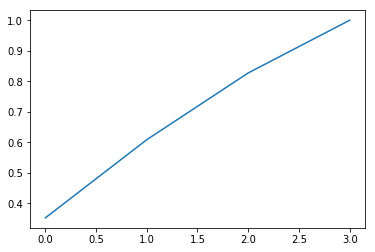

In [232]:
variance_cumsum = table['Explained Variance'].cumsum()
var_list = variance_cumsum.tolist()
plt.plot(var_list);

In [233]:
def scree_plot(pca): # Copied from helper functions in lessons
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

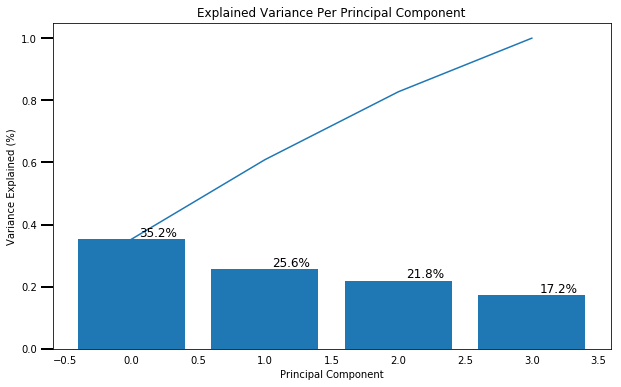

In [235]:
scree_plot(pca)
pca, X_pca = do_pca(df_scaled_sub, 4)

In [236]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Function for finding weights for principal components
def list_weights(df, pca, component):
    table = pca_results(df, pca, False)
    row = table.iloc[component-1,1:].sort_values(ascending=False)
    weights_descending = row.tolist()
    features_descending = row.index.tolist()
    return weights_descending, features_descending

# weights and features for 1st component
weights, features = list_weights(df_scaled_sub, pca, 1)
print(weights)
print('\n')
print(features)

[0.6442, 0.6088, 0.0565, -0.4596]


['income', 'age', 'became_member_on', 'gender']


In [238]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights, features = list_weights(df_scaled_sub, pca, 2)
print(weights)
print('\n')
print(features)

[0.3407, 0.1942, 0.1392, -0.9093]


['gender', 'age', 'income', 'became_member_on']


In [239]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights, features = list_weights(df_scaled_sub, pca, 3)
print(weights)
print('\n')
print(features)

[-0.1542, -0.4045, -0.4107, -0.8025]


['income', 'age', 'became_member_on', 'gender']


In [240]:
# Map weights for the fourth principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights, features = list_weights(df_scaled_sub, pca, 4)
print(weights)
print('\n')
print(features)

[0.6542, -0.0365, -0.1697, -0.7361]


['age', 'became_member_on', 'gender', 'income']


In [216]:
from sklearn.cluster import KMeans

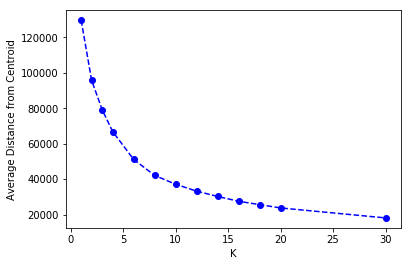

In [241]:
def k_means_clusters_score(df, number_of_cluster):

    kmeans = KMeans(n_clusters = number_of_cluster)

    model = kmeans.fit(df)

    score = np.abs(model.score(df))

    return score


scores = []

kvalues = [1,2,3,4,6,8,10,12,14,16,18,20,30]

for k in kvalues:
    scores.append(k_means_clusters_score(df_scaled_sub, k))

plt.plot(kvalues, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Average Distance from Centroid');

In [242]:
# go with 10 clusters?

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 10)
model = kmeans.fit(df_scaled_sub)
labels = model.predict(df_scaled_sub)

(array([ 3610.,  2400.,  2378.,  4214.,  3422.,  4380.,  3088.,  2565.,
         2687.,  3651.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

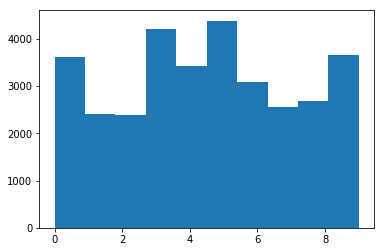

In [243]:
# Rough look at distribution
labels
plt.hist(labels)

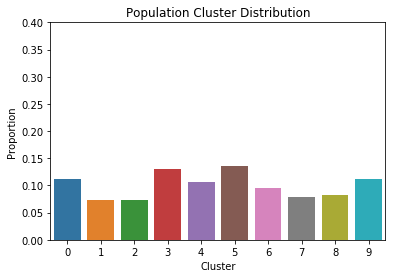

In [247]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


# Plot principal components for general population

population_cluster_counts=pd.DataFrame(labels)
population_cluster_counts.columns=['cluster']
pop_counts = population_cluster_counts.cluster.value_counts()

ord = [0,1,2,3,4,5,6,7,8,9]
ax = sns.barplot(x=pop_counts.index,y=pop_counts.values/pop_counts.values.sum(),order=ord);
ax.set(xlabel='Cluster', ylabel='Proportion', title='Population Cluster Distribution', ylim=(0,0.4))
plt.show()

In [249]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

weights, features = list_weights(df_scaled_sub, pca, 4)
print(weights)
print('\n')
print(features)

[0.6542, -0.0365, -0.1697, -0.7361]


['age', 'became_member_on', 'gender', 'income']


So, I don't think k-means clustering is right for this project - there aren't enough demographic variables I think

Instead, compare complete to incomplete offers for different groups of people